In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from Games import *
import Utility
from os import listdir
from os.path import join
from json import load
from glob import glob

In [3]:
PALETTE = {
    "policy": "red", 
    "q": "blue", 
    "random": "green", 
    "GreedyRelative": "purple"
}

In [4]:
def get_agent_playthroughs(config, allow_empty_link):
    playthroughs = []
    for filename in listdir(config.BASE_DIR):
        if filename.startswith('fitagent_playthrough_') and str(allow_empty_link) in filename:
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [5]:
def get_player_playthroughs(config, player_name):
    playthroughs = []
    starts_with_str = f'player_{player_name}_fit_playthrough_{config.NAME}'
    
    for filename in listdir(config.BASE_DIR):
        if filename.startswith(starts_with_str):
            with open(join(config.BASE_DIR, filename), 'r') as f:
                data = load(f)
                playthroughs.append((filename, data))
            
    return playthroughs

In [6]:
def plot_reward_over_time(playthroughs):
    plot_data = {}
    for filename, data in playthroughs:
        legend_name = filename.split('.')[0].split('_')[-2]
        plot_data[legend_name] = []
        total_reward = 0
        
        for level in data:
            for _, _, _, r in level:
                total_reward += r
            
            plot_data[legend_name].append(total_reward)
    
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.lineplot(data=plot_data, palette=PALETTE)
    ax.set_title('Reward over Time')
    ax.set_xlabel('Level')
    ax.set_ylabel('Reward')
        
    plt.show()

In [7]:
def heatmap(playthroughs, graph, bounds, game):
    max_x, max_y = bounds
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,4))
    cbar_ax = fig.add_axes([.92, .1, .02, .8])
    fig.suptitle(f'Cells Visited by Director for {game}')
    for i, (filename, playthrough_data) in enumerate(playthroughs):
        # build heatmap matrix for data and for the mask which blocks out
        # cells that are not in the graph
        data = np.zeros((max_x + 1, max_y + 1))
        mask = np.ones((max_x + 1, max_y + 1))
        for n in graph.nodes:
            if '__' in n:
                continue

            a,b,_ = n.split(',')
            mask[int(a)][int(b)] = 0.0

        for run in playthrough_data:
            for segment, _, _, _ in run:
                if '__' in segment:
                    continue

                a, b, _ = segment.split(',')
                data[int(a)][int(b)] += 1.0

        # build the heatmap
        ax = sns.heatmap(
            data, 
            mask=mask,
            square=True,
            cmap='Blues',
            ax=axes[i],
            cbar_ax=None if i != 3 else cbar_ax,
            cbar=i==3
        )

        director = filename.split('_')[-2]
        axes[i].invert_yaxis()
        axes[i].set_title(f'{director}', y=-0.1)
        axes[i].set_facecolor("gray")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_aspect('auto')

        # reduce frequency for xticks
        for ind, label in enumerate(axes[i].get_xticklabels()):
            if ind % 5 == 0:  
                label.set_visible(True)
            else:
                label.set_visible(False)

        # reduce frequency for y ticks
        for ind, label in enumerate(axes[i].get_yticklabels()):
            if ind % 5 == 0:  
                label.set_visible(True)
            else:
                label.set_visible(False)

    plt.show()

## Agent :: DungeonGrams

In [8]:
config = DungeonGrams
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_True.json


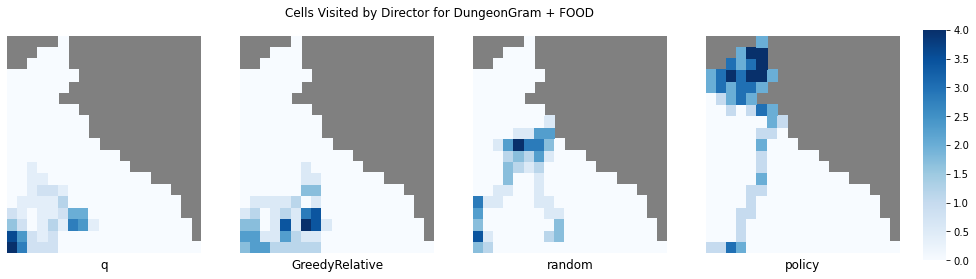

In [9]:
heatmap(playthroughs, graph, config.MAX_BC, f'{config.NAME} + FOOD')

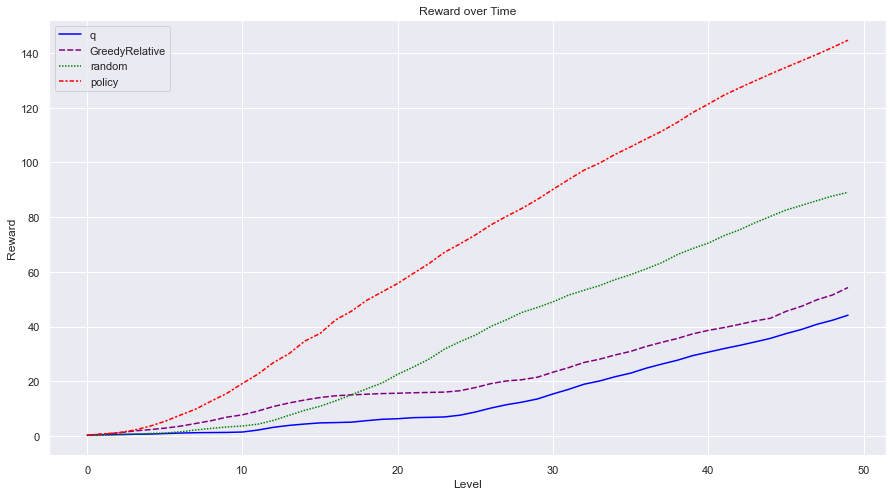

In [10]:
plot_reward_over_time(playthroughs)

## Agent :: DungeonGrams + Food

In [11]:
config = DungeonGrams
graph = Utility.get_graph(config, False)
playthroughs = get_agent_playthroughs(config, False)

Loading links from: ./GramElitesData/DungeonData/gram_elites/links_False.json


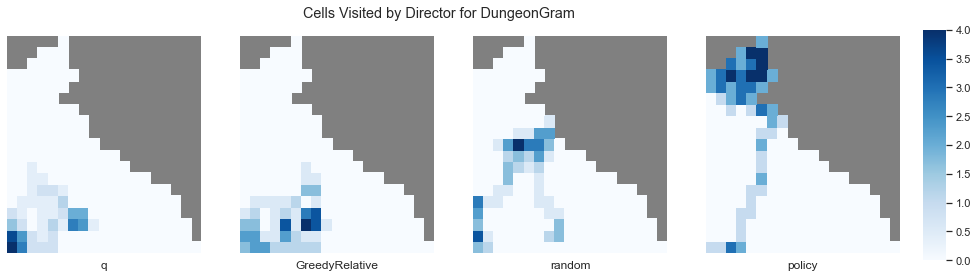

In [12]:
heatmap(playthroughs, graph, config.MAX_BC, config.NAME)

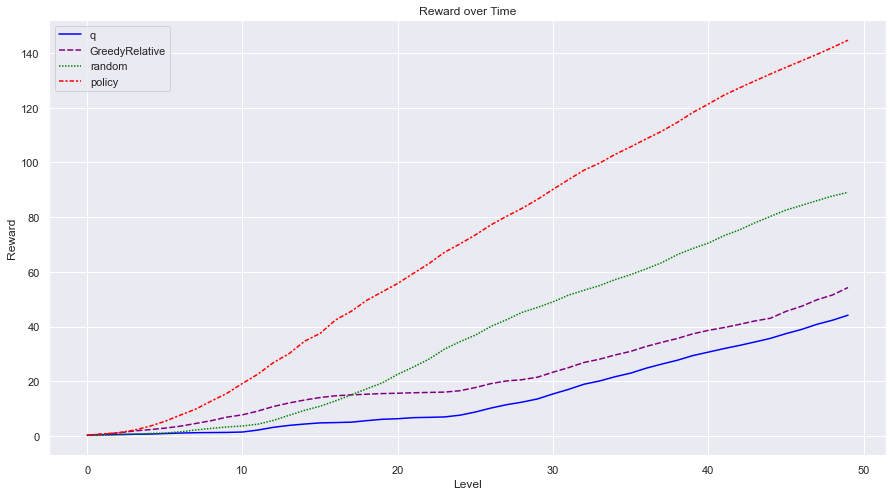

In [13]:
plot_reward_over_time(playthroughs)

## Agent :: Mario

In [14]:
config = Mario
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


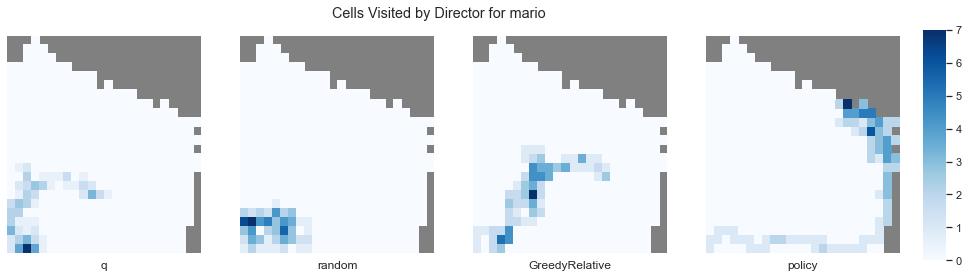

In [15]:
heatmap(playthroughs, graph, config.MAX_BC, config.NAME)

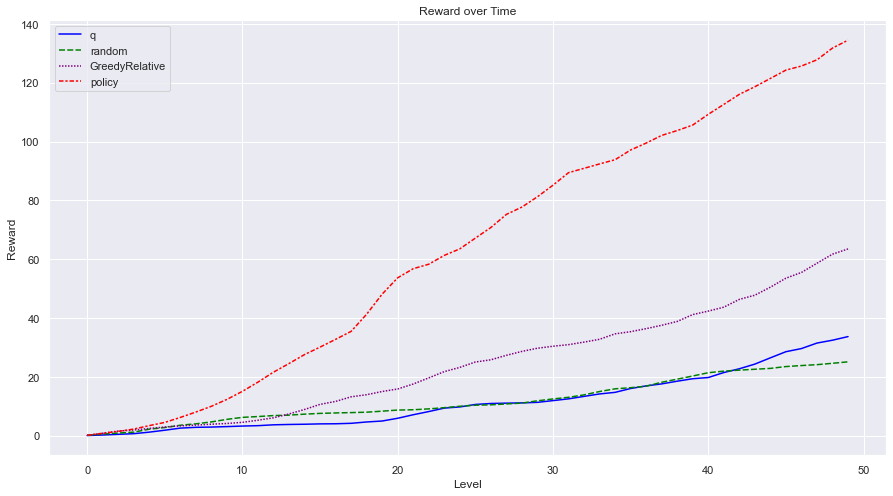

In [16]:
plot_reward_over_time(playthroughs)

## Agent ::  Icarus

In [17]:
config = Icarus
graph = Utility.get_graph(config, True)
playthroughs = get_agent_playthroughs(config, True)

Loading links from: ./GramElitesData/IcarusData/gram_elites/links_True.json


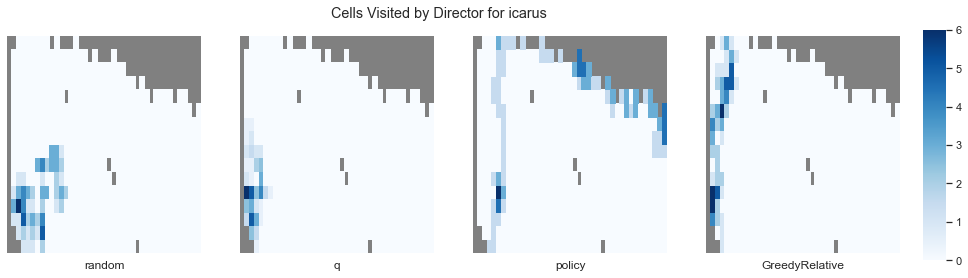

In [18]:
heatmap(playthroughs, graph, config.MAX_BC, config.NAME)

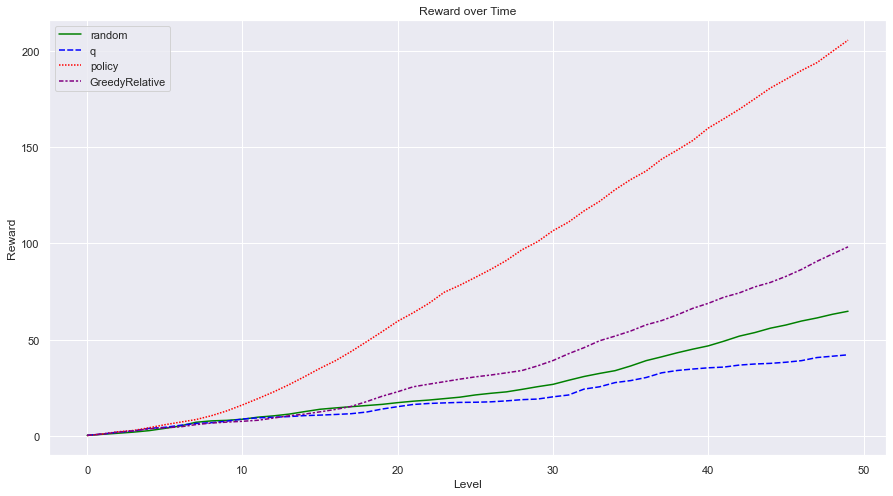

In [19]:
plot_reward_over_time(playthroughs)

# Player Personas

In [20]:
def get_all_player_playthroughs(config, allow_empty_link, reward_str):
    playthroughs = []
    for path in glob(join(config.BASE_DIR, f'player_*_{allow_empty_link}_reward_{reward_str}.json')):
        path_split = path.split('/')[-1].split('_')
        player = path_split[1]
        director = path_split[-5]
        
        with open(path, 'r') as f:
            playthroughs.append((player, director, load(f)))

    return playthroughs

In [21]:
def get_df(playthroughs, order_column):
    data = []
    labels = ['Director', 'Player', 'Percent Complete', 'Player Reward', 'Design Reward','Total Reward']
    players = set()
    RUNS_SIZE = len(player_playthroughs[2][2][0])
    
    for player, director, run_data in playthroughs:
        players.add(player)
        for run in run_data:
            run_percent_complete = 0
            run_player_reward = 0
            run_design_reward = 0
            run_total_reward = 0

            for lvl in run:
                run_percent_complete += lvl['percent_complete']
                run_player_reward += lvl['percent_player_reward']
                run_design_reward += lvl['percent_design_reward']
                run_total_reward += lvl['percent_total_reward']
                    
            data.append((
                director, 
                player, 
                run_percent_complete / RUNS_SIZE, 
                run_player_reward / RUNS_SIZE, 
                run_design_reward / RUNS_SIZE, 
                run_total_reward / RUNS_SIZE))
            
    df = pd.DataFrame(data, columns=labels) \
         .groupby(['Player', 'Director']) \
         .agg(['mean', 'std']) \
         .sort_values(by=['Player', (order_column, 'mean')], ascending=False)
    df = df.applymap("{0:.3f}".format)
    return df

In [22]:
def plot_player_personas_over_time(playthroughs, column, reward_name):
    player_data = {}
    for player, alg, data in player_playthroughs:
        if player not in player_data:
            player_data[player] = []
            
        for session in data:
            total_reward = 0
            for i, lvl in enumerate(session):
                total_reward += lvl[column]
                player_data[player].append((alg, i, total_reward))
                
    # sort keys so the output is always in the same order
    player_names = list(player_data.keys())
    player_names.sort()
    
    # build plots and set title
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16,8))
    fig.suptitle(f'Reward Over Time for {reward_name}')
    
    # fill in each plot
    for i, player in enumerate(player_names):
        plot_df = pd.DataFrame(player_data[player], columns=['alg', 'level', 'reward'])
        
        if i >= 4:
            x,y = i-4, 1
        else:
            x,y = i, 0
            
        ax = sns.lineplot(ax=axes[y, x], data=plot_df, x='level', y='reward', hue='alg', palette=PALETTE)
        ax.get_legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(player)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.9, 0.99))
    fig.text(0.5, 0.04, 'Level', ha='center', size=14)
    fig.text(0.08, 0.5, 'Reward', va='center', rotation='vertical', size=14)
    plt.show()

## Mario
### R=Desiner

In [23]:
config = Mario
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
graph = Utility.get_graph(config, True)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

Loading links from: ./GramElitesData/MarioData/gram_elites/links_True.json


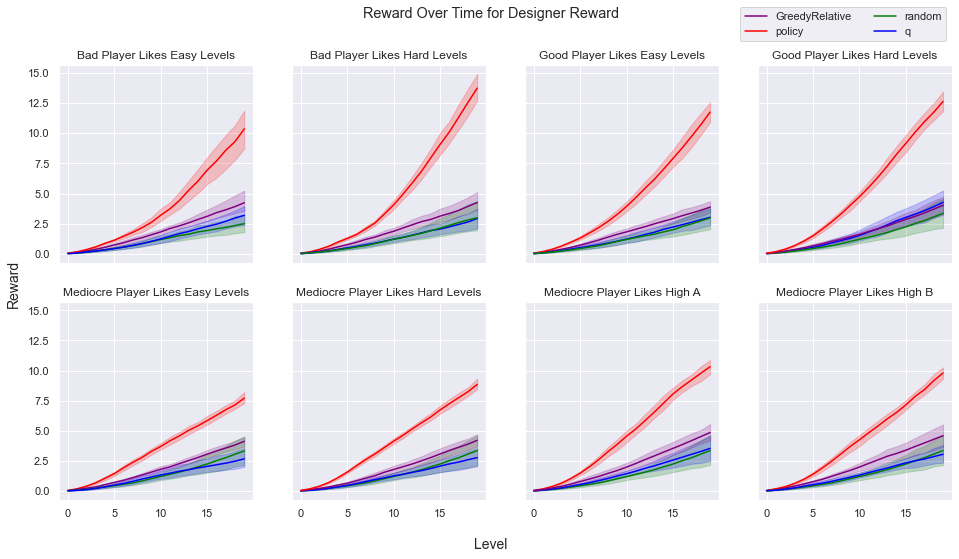

In [24]:
plot_player_personas_over_time(player_playthroughs, 'percent_design_reward', 'Designer Reward')

### R=Player

In [25]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Player Reward')
mario_player_persona_player_table = df.to_latex() # store in case we want it

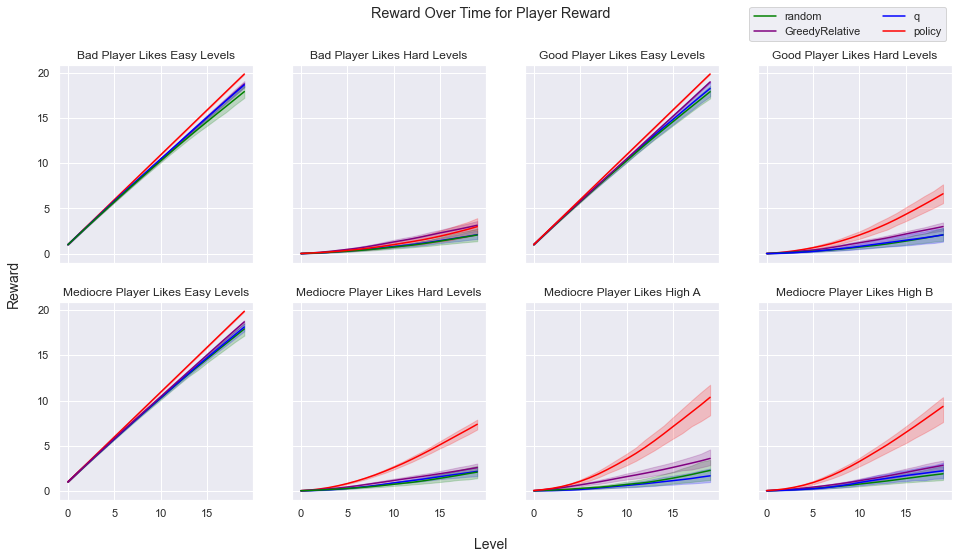

In [26]:
plot_player_personas_over_time(player_playthroughs, 'percent_player_reward', 'Player Reward')

### R=Both

In [27]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Player Reward')
mario_player_persona_player_table = df.to_latex() # store in case we want it

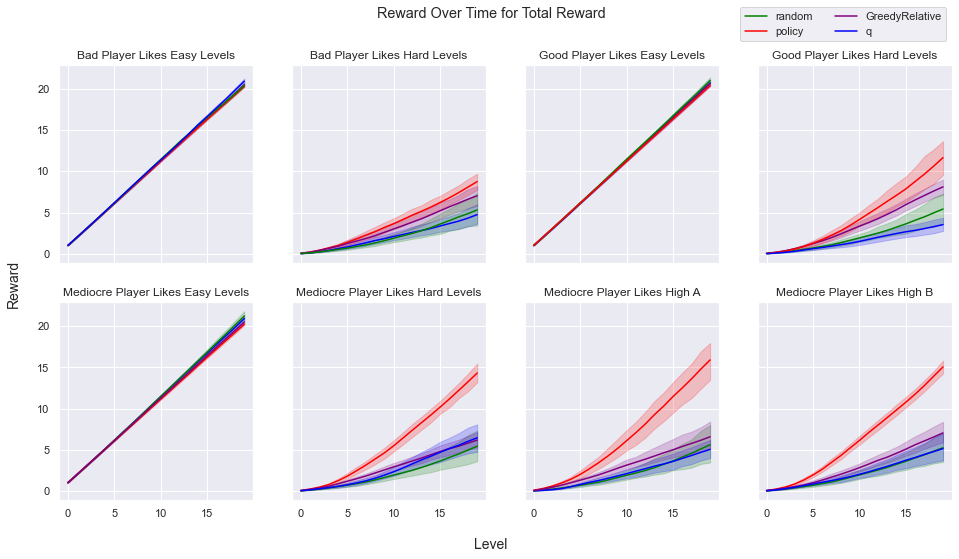

In [28]:
plot_player_personas_over_time(player_playthroughs, 'percent_total_reward', 'Total Reward')

## Icarus
### R=Designer

In [29]:
config = Icarus
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

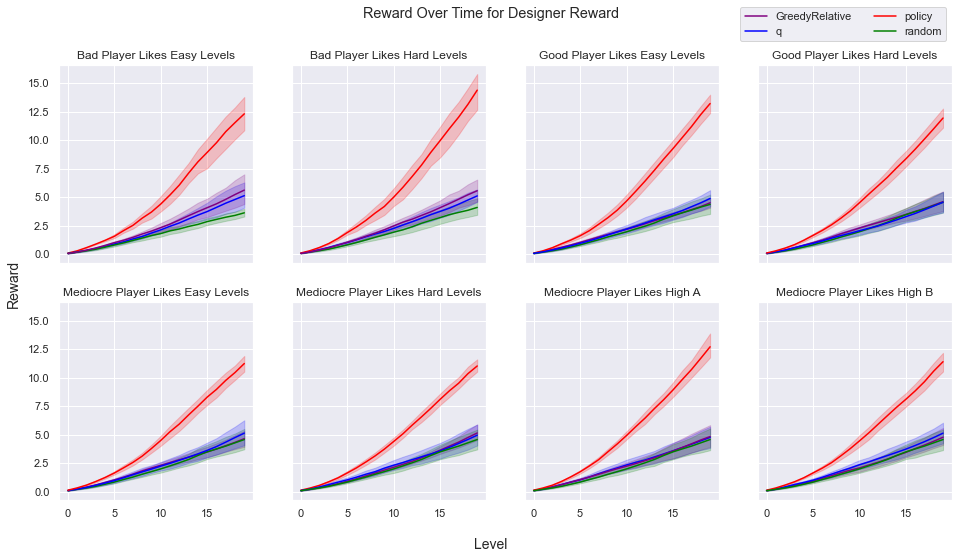

In [30]:
plot_player_personas_over_time(player_playthroughs, 'percent_design_reward', 'Designer Reward')

### R=Player

In [31]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

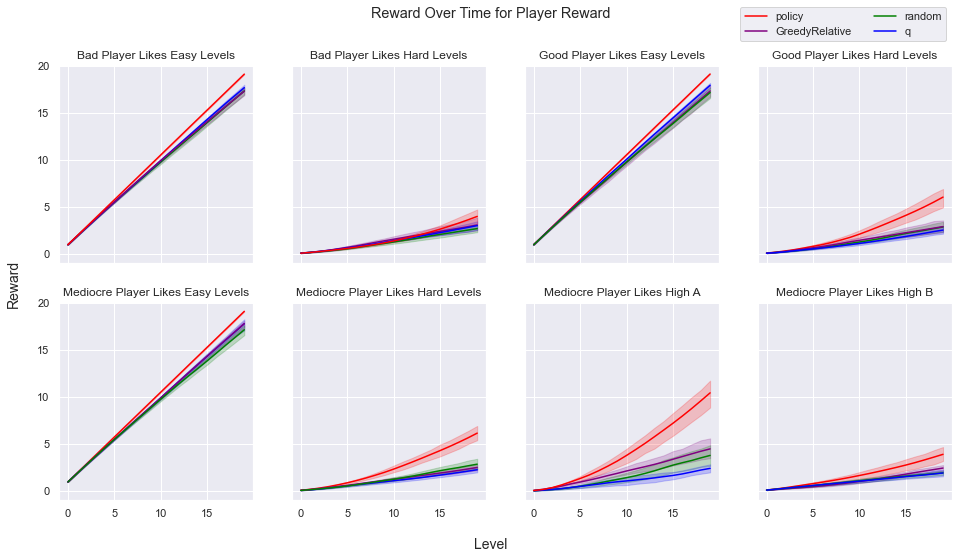

In [32]:
plot_player_personas_over_time(player_playthroughs, 'percent_player_reward', 'Player Reward')

### R=Both

In [33]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
player_playthroughs = get_all_player_playthroughs(config, True, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

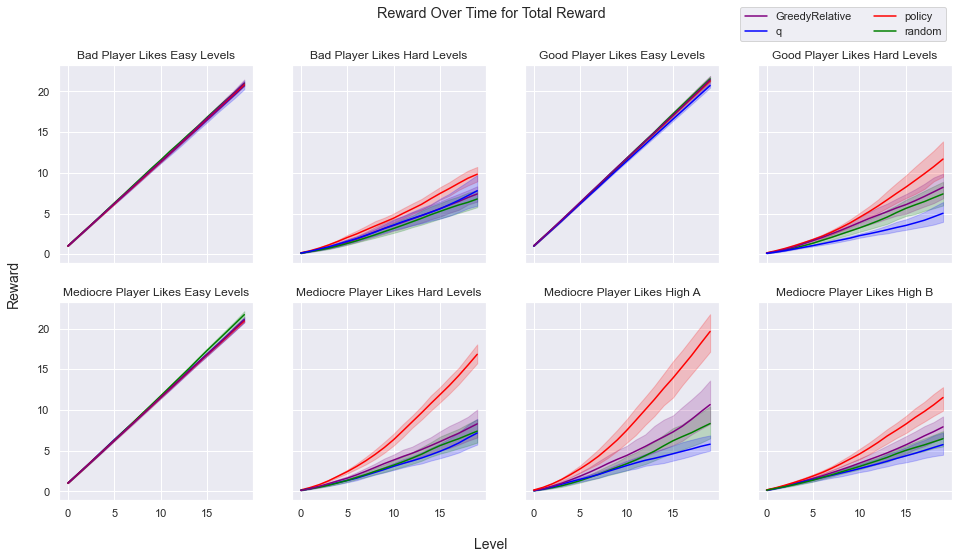

In [34]:
plot_player_personas_over_time(player_playthroughs, 'percent_total_reward', 'Total Reward')

## DungeonGram
### R=Designer

In [35]:
config = DungeonGrams
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.DESIGNER)
player_playthroughs = get_all_player_playthroughs(config, False, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

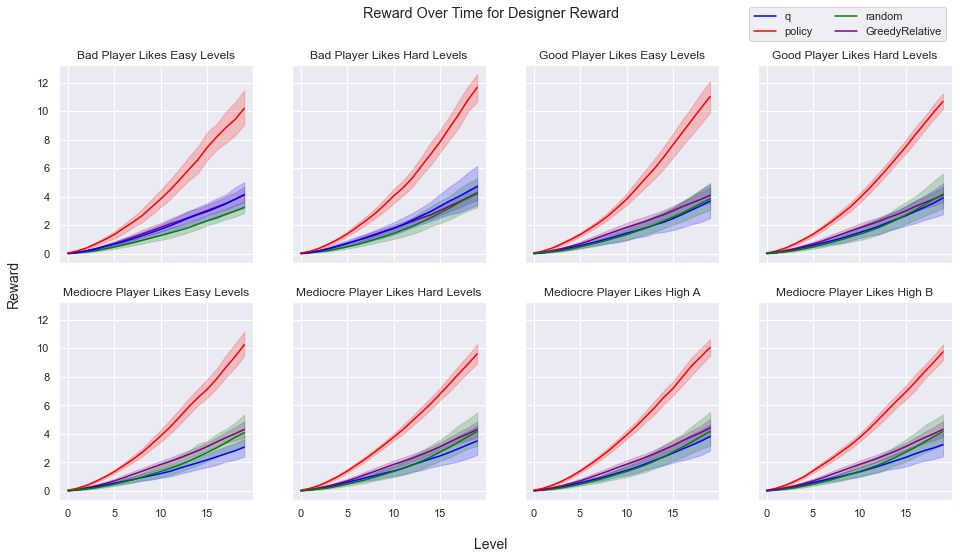

In [36]:
plot_player_personas_over_time(player_playthroughs, 'percent_design_reward', 'Designer Reward')

### R=Player

In [37]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.PLAYER)
player_playthroughs = get_all_player_playthroughs(config, False, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

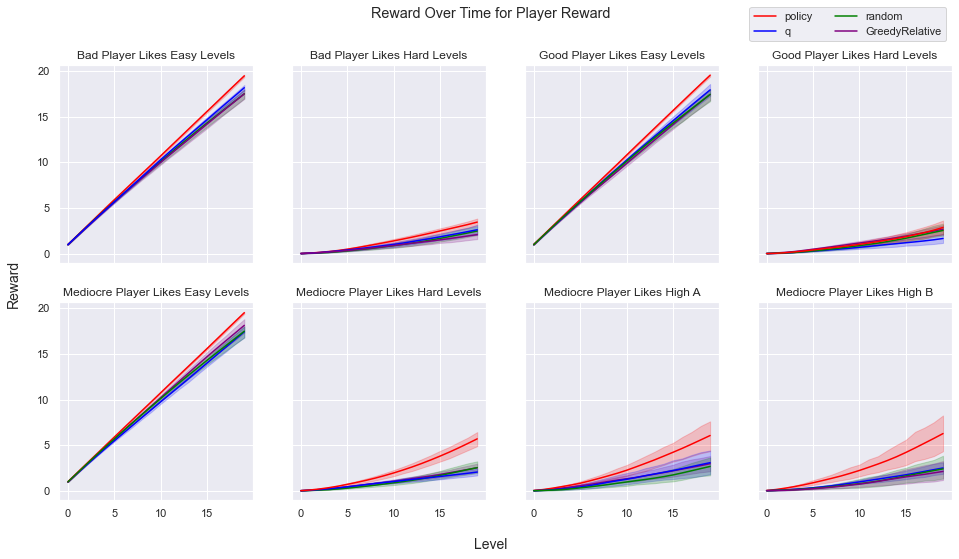

In [38]:
plot_player_personas_over_time(player_playthroughs, 'percent_player_reward', 'Player Reward')

### R=Both

In [39]:
REWARD_STR = Utility.reward_type_to_str(Utility.RewardType.BOTH)
player_playthroughs = get_all_player_playthroughs(config, False, REWARD_STR)
df = get_df(player_playthroughs, 'Design Reward')
mario_player_persona_designer_table = df.to_latex() # store in case we want it

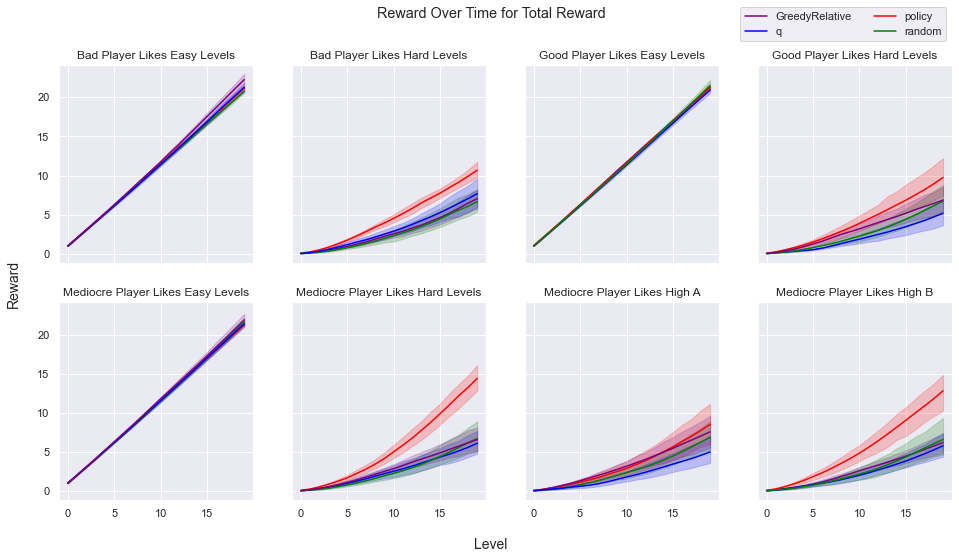

In [40]:
plot_player_personas_over_time(player_playthroughs, 'percent_total_reward', 'Total Reward')